In [1]:
import sys
sys.path.append('..')

from helper_fun import *
import helper_fun

# Silence some expected warnings
filterwarnings("ignore")

from Split_functions_regression.split_furthest_cluster import *
from Split_functions_regression.split_hierarchical_cluster import *
from Split_functions_regression.split_random import *
from Split_functions_regression.split_strat_pIC50 import *
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

SEED = 42
seed_everything(SEED)
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

compounds = pd.read_csv('../COVID_MOONSHOT/compounds_filtered.csv')

2024-07-26 16:22:41.795137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Neural Network Model

In [2]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# Splits

In [3]:
compounds["Fingerprints"] = compounds["SMILES"].apply(smiles_to_fp)
x_train_rand, x_test_rand, y_train_rand, y_test_rand = random_split(compounds["Fingerprints"], compounds["f_avg_pIC50"])
x_train_strat, x_test_strat, y_train_strat, y_test_strat = strat_pIC50_split(compounds)
x_train_hi, x_test_hi, y_train_hi, y_test_hi = split_hierarchical_clusters(compounds, test_size=0.2, random_state=42)
x_train_noise, x_test_noise, y_train_noise, y_test_noise = UMAP_noise_split(compounds)
x_train_fur, x_test_fur, y_train_fur, y_test_fur = furthest_cluster_split(compounds)
# print(f"Shape of train_x: {train_x.shape}") (476,)
# print(f"Shape of test_x: {test_y.shape}") (119,)


Assign cluster ID


  0%|          | 0/595 [00:00<?, ?it/s][16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPRECATION WARNING: please use MorganGenerator
[16:23:01] DEPREC

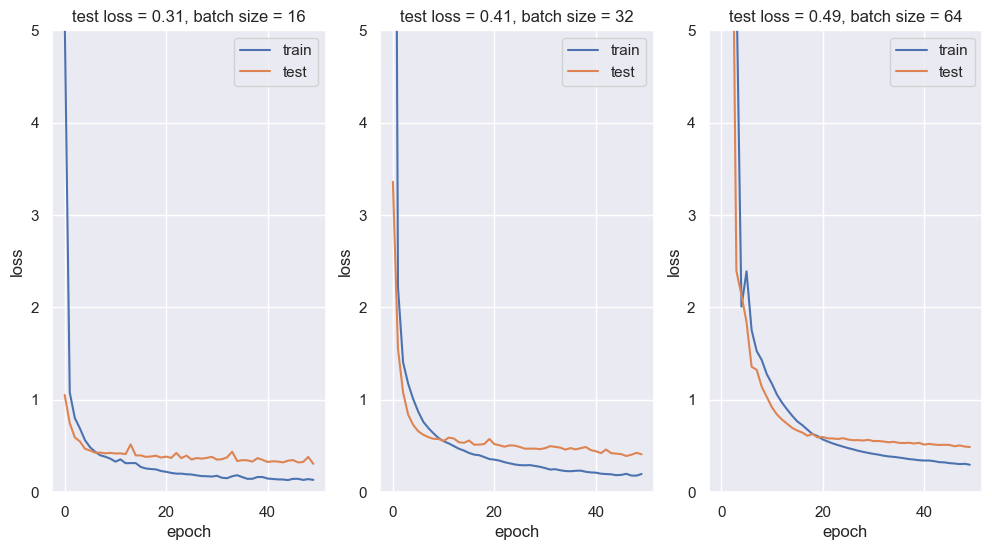

In [5]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train_rand))).astype(float), y_train_rand.values, batch_size=batch, validation_data=(np.array(list((x_test_rand))).astype(float), y_test_rand.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

### Model does best with a batch size of 32

In [6]:
# Save the trained model
filepath = DATA / "best.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train_rand))).astype(float),
    y_train_rand.values,
    epochs=nb_epoch,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=0,
)

In [7]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test_rand))), y_test_rand.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.36
 mse (same as loss): 0.36
 mae: 0.43


In [8]:
# Predict pIC50 values on x_test data
y_pred_rand = model.predict(np.array(list((x_test_rand))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred_rand[0:5]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5.36
5.18
4.74
5.82
4.82


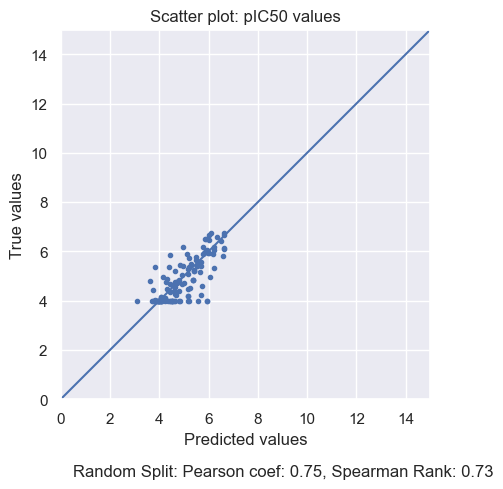

In [9]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rand, y_test_rand, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (random split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_rand = np.corrcoef(y_pred_rand.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rand = spearmanr(y_pred_rand.flatten(), y_test_rand.values.flatten()).correlation
fig.text(0.9, -0.05, f"Random Split: Pearson coef: {pearsoncoef_rand:.2f}, Spearman Rank: {spearmancoef_rand:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# Strat Split

In [10]:
print(y_train_strat)
print(y_test_strat)

43     4.427046
453    4.002177
376    5.263954
91     4.013475
452    4.059631
         ...   
562    6.365817
495    5.749483
394    4.002177
201    4.002177
145    4.002177
Name: f_avg_pIC50, Length: 476, dtype: float64
507    6.655152
464    5.896846
26     5.561432
533    4.002177
31     4.831952
         ...   
36     4.916740
29     5.361479
251    5.144261
535    4.002177
349    4.697309
Name: f_avg_pIC50, Length: 119, dtype: float64


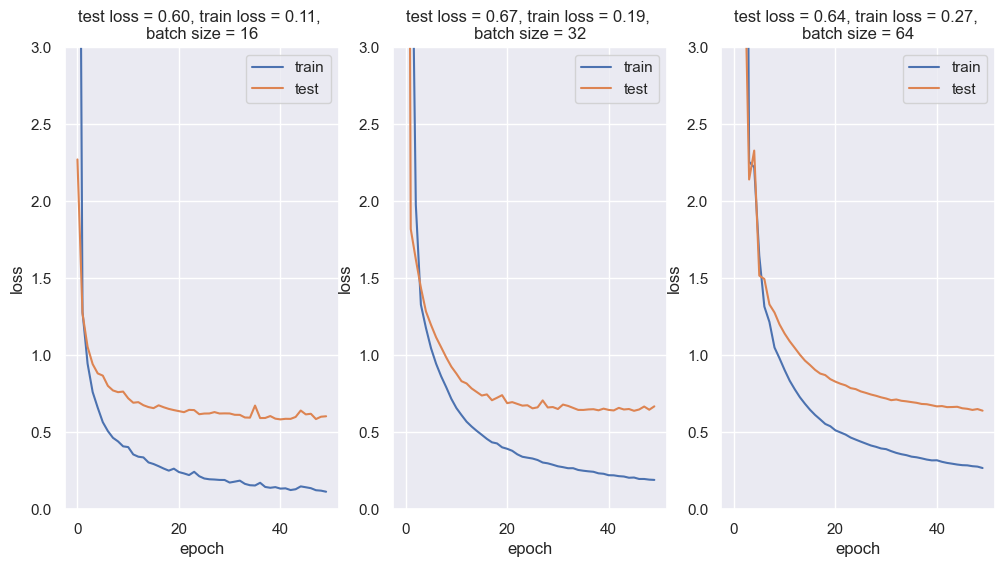

In [13]:
# Neural network parameters
#number of training samples used in one forward/backward pass
batch_sizes = [16, 32, 64]
# epoch is one complete pass through the entire training dataset.
#higher epoch can improve model performance but may lead to overfitting
nb_epoch = 50
#number of neurons in the first and secondb hidden layer 
layer1_size = 64
layer2_size = 32

# Plot test loss scores
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_strat = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_strat = model_strat.fit(
        np.array(list((x_train_strat))).astype(float),
        y_train_strat.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test_strat))).astype(float), y_test_strat.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history_strat.history["loss"], label="train")
    plt.plot(history_strat.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 3))
    plt.title(
        f"test loss = {history_strat.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_strat.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

### Test and train loss seem to be lowest with batch size of 16

In [15]:
# Save the trained model
filepath = DATA / "best.strat.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_strat.fit(
    np.array(list((x_train_strat))).astype(float),
    y_train_strat.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: Stratified Split (pIC50 values)")
scores_strat = model_strat.evaluate(np.array(list((x_test_strat))), y_test_strat.values, verbose=0)
print(f" loss: {scores_strat[0]:.2f}")
print(f" mse (same as loss): {scores_strat[1]:.2f}")
print(f" mae: {scores_strat[2]:.2f}")

Evaluate the ANN model on the test data: Stratified Split (pIC50 values)
 loss: 0.71
 mse (same as loss): 0.71
 mae: 0.55


In [16]:
# Predict pIC50 values on x_test data
y_pred_strat = model_strat.predict(np.array(list((x_test_strat))))

# Print 5 first pIC50 predicted values
first_5_prediction_strat = [print(f"{value[0]:.2f}") for value in y_pred_strat[0:5]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6.65
4.98
5.51
3.43
5.06


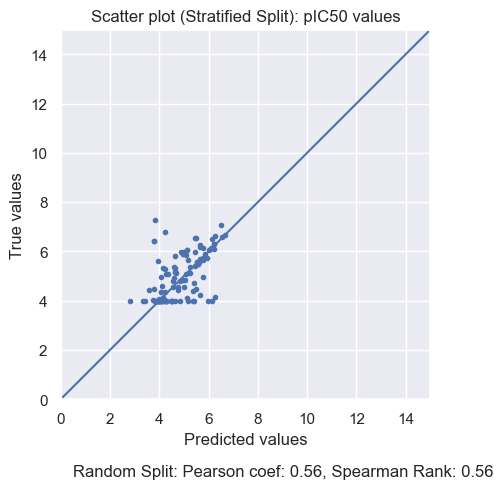

In [17]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_strat, y_test_strat, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Stratified Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_strat = np.corrcoef(y_pred_strat.flatten(), y_test_strat.values.flatten())[0,1]
spearmancoef_strat = spearmanr(y_pred_strat.flatten(), y_test_strat.values.flatten()).correlation
fig.text(0.9, -0.05, f"Stratified Split: Pearson coef: {pearsoncoef_strat:.2f}, Spearman Rank: {spearmancoef_strat:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# Hierarchical Clustering Split

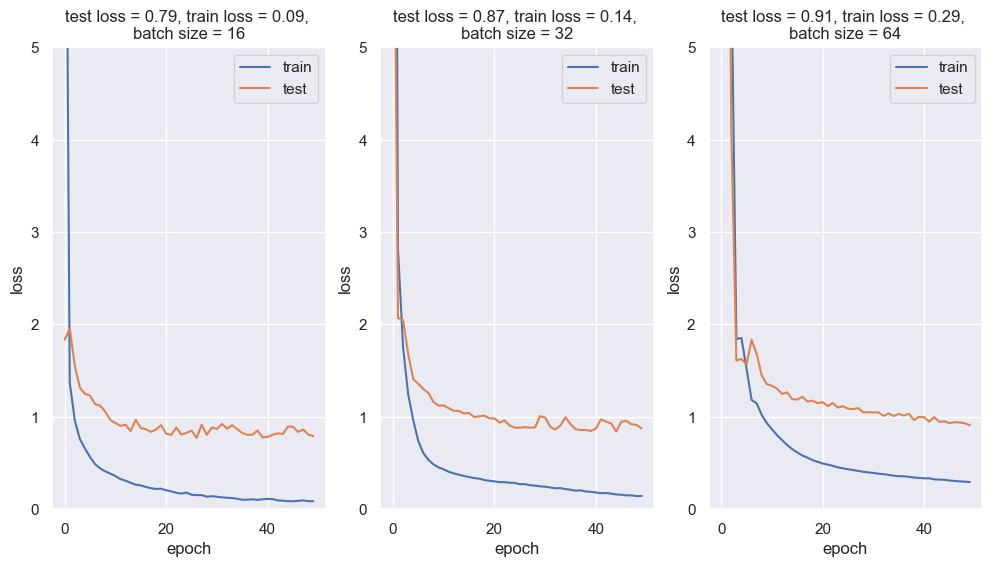

In [18]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_hi = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_hi = model_hi.fit(
        np.array(list((x_train_hi))).astype(float), y_train_hi.values, batch_size=batch, validation_data=(np.array(list((x_test_hi))).astype(float), y_test_hi.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history_hi.history["loss"], label="train")
    plt.plot(history_hi.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history_hi.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_hi.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

In [19]:
# Save the trained model
filepath = DATA / "best.hierarc.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_hi.fit(
    np.array(list((x_train_hi))).astype(float),
    y_train_hi.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: Hierarchical Cluster Split")
scores_hi = model_hi.evaluate(np.array(list((x_test_hi))), y_test_hi.values, verbose=0)
print(f" loss: {scores_hi[0]:.2f}")
print(f" mse (same as loss): {scores_hi[1]:.2f}")
print(f" mae: {scores_hi[2]:.2f}")

Evaluate the ANN model on the test data: Hierarchical Cluster Split
 loss: 0.81
 mse (same as loss): 0.81
 mae: 0.69


In [20]:
# Predict pIC50 values on x_test data
y_pred_hi = model_hi.predict(np.array(list((x_test_hi))))

# Print 5 first pIC50 predicted values
first_5_prediction_hi = [print(f"{value[0]:.2f}") for value in y_pred_hi[0:5]]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x164d6de40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
5.12
5.08
5.13
5.65
5.23


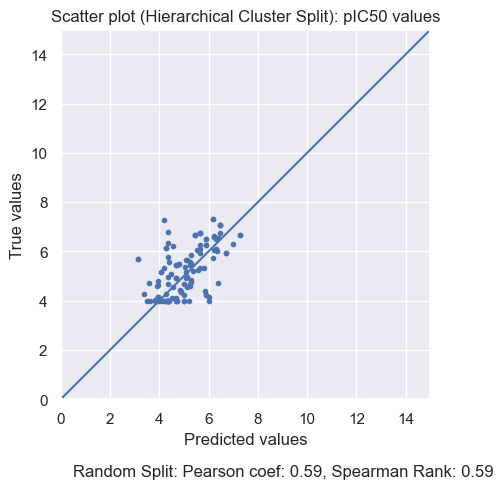

In [21]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_hi, y_test_hi, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Hierarchical Cluster Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_hi = np.corrcoef(y_pred_hi.flatten(), y_test_hi.values.flatten())[0,1]
spearmancoef_hi = spearmanr(y_pred_hi.flatten(), y_test_hi.values.flatten()).correlation
fig.text(0.9, -0.05, f"Hierarchical Cluster Split: Pearson coef: {pearsoncoef_hi:.2f}, Spearman Rank: {spearmancoef_hi:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# UMAP Furthest Cluster Split

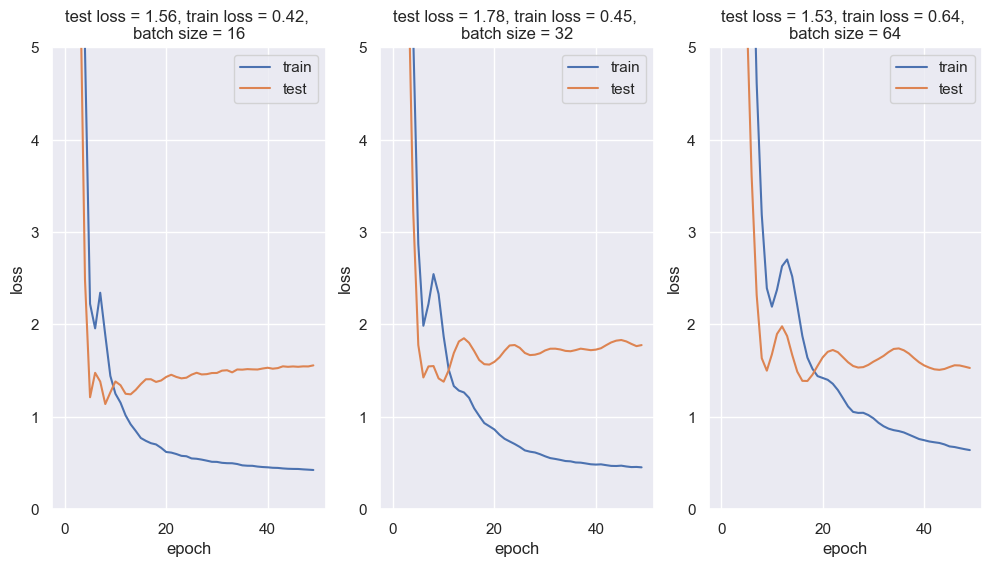

In [22]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_fur = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_fur = model_fur.fit(
        np.array(list((x_train_fur))).astype(float), y_train_fur.values, batch_size=batch, validation_data=(np.array(list((x_test_fur))).astype(float), y_test_fur.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history_fur.history["loss"], label="train")
    plt.plot(history_fur.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history_fur.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_fur.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

In [23]:
# Save the trained model
filepath = DATA / "best.fur.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_fur.fit(
    np.array(list((x_train_fur))).astype(float),
    y_train_fur.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: UMAP Furthest Cluster Split")
scores_fur = model_fur.evaluate(np.array(list((x_test_fur))), y_test_fur.values, verbose=0)
print(f" loss: {scores_fur[0]:.2f}")
print(f" mse (same as loss): {scores_fur[1]:.2f}")
print(f" mae: {scores_fur[2]:.2f}")

Evaluate the ANN model on the test data: UMAP Furthest Cluster Split
 loss: 1.63
 mse (same as loss): 1.63
 mae: 1.00


In [24]:
# Predict pIC50 values on x_test data
y_pred_fur = model_fur.predict(np.array(list((x_test_fur))))

# Print 5 first pIC50 predicted values
first_5_prediction_fur = [print(f"{value[0]:.2f}") for value in y_pred_fur[0:5]]

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4.53
4.75
4.03
4.83
3.99


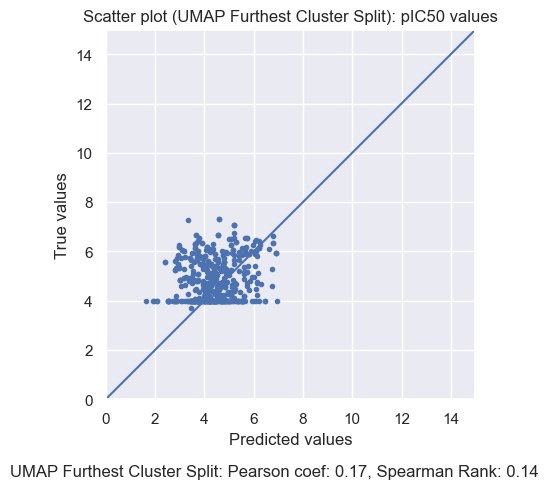

In [25]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_fur, y_test_fur, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (UMAP Furthest Cluster Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_fur = np.corrcoef(y_pred_fur.flatten(), y_test_fur.values.flatten())[0,1]
spearmancoef_fur = spearmanr(y_pred_fur.flatten(), y_test_fur.values.flatten()).correlation
fig.text(0.9, -0.05, f"UMAP Furthest Cluster Split: Pearson coef: {pearsoncoef_fur:.2f}, Spearman Rank: {spearmancoef_fur:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# UMAP Noise Split


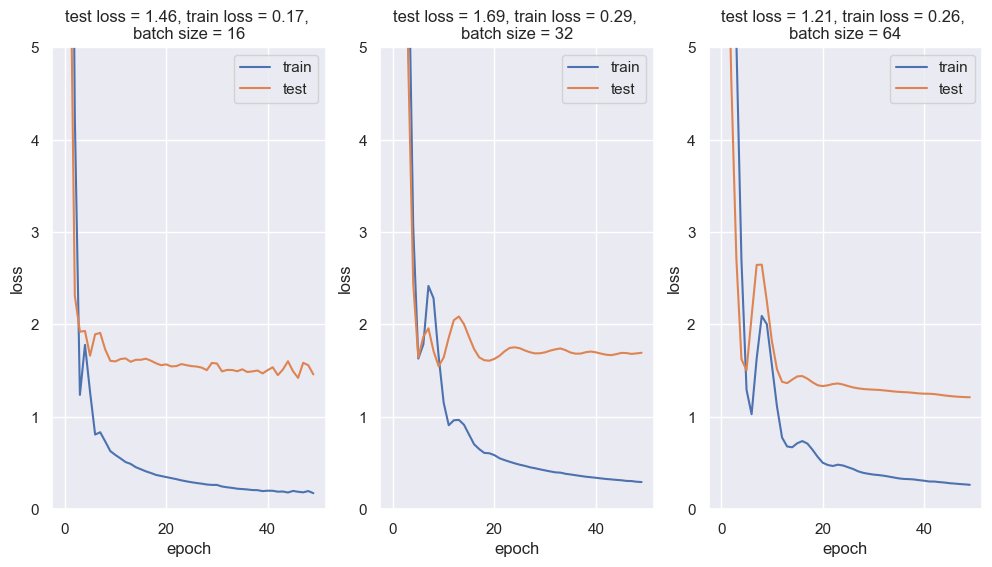

In [26]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_noise = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_noise = model_noise.fit(
        np.array(list((x_train_noise))).astype(float), y_train_noise.values, batch_size=batch, validation_data=(np.array(list((x_test_noise))).astype(float), y_test_noise.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history_noise.history["loss"], label="train")
    plt.plot(history_noise.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history_noise.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_noise.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

In [27]:
# Save the trained model
filepath = DATA / "best.noise.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_noise.fit(
    np.array(list((x_train_noise))).astype(float),
    y_train_noise.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: Hierarchical Cluster Split")
scores_noise = model_noise.evaluate(np.array(list((x_test_noise))), y_test_noise.values, verbose=0)
print(f" loss: {scores_noise[0]:.2f}")
print(f" mse (same as loss): {scores_noise[1]:.2f}")
print(f" mae: {scores_noise[2]:.2f}")

Evaluate the ANN model on the test data: Hierarchical Cluster Split
 loss: 1.14
 mse (same as loss): 1.14
 mae: 0.86


In [28]:
# Predict pIC50 values on x_test data
y_pred_noise = model_noise.predict(np.array(list((x_test_noise))))

# Print 5 first pIC50 predicted values
first_5_prediction_noise = [print(f"{value[0]:.2f}") for value in y_pred_noise[0:5]]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4.15
4.04
3.85
4.01
3.09


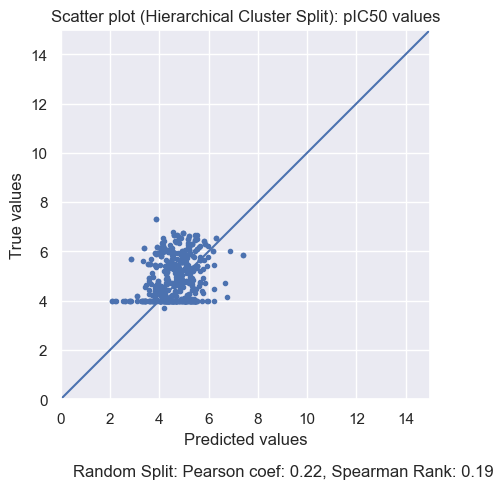

In [29]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_noise, y_test_noise, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Hierarchical Cluster Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_noise = np.corrcoef(y_pred_noise.flatten(), y_test_noise.values.flatten())[0,1]
spearmancoef_noise = spearmanr(y_pred_noise.flatten(), y_test_noise.values.flatten()).correlation
fig.text(0.9, -0.05, f"Random Split: Pearson coef: {pearsoncoef_noise:.2f}, Spearman Rank: {spearmancoef_noise:.2f}", horizontalalignment='right', fontsize=12)
plt.show()